<a href="https://colab.research.google.com/github/tikhongc/fyp/blob/main/Music_emotion_VotingClassifier(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install scikeras
from scikeras.wrappers import KerasClassifier
# Define pipelines
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.ensemble import VotingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import make_classification
from keras.layers import Dense
from keras.models import Sequential


In [ ]:
# Install and update essential libraries and tools
!pip install xgboost -U
!pip install librosa -U
# !apt-get --yes install ffmpeg
!pip install hyperopt

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn import datasets


from xgboost import XGBClassifier

#For hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
import sklearn.metrics as metrics

# load libraries
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import seaborn as sns
#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
#from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf

In [ ]:
!pip install --upgrade lightgbm

In [ ]:
# model used for feature importances
import lightgbm as lgb
lgb.__version__

'3.3.2'

In [ ]:


# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# memory management
import gc

# utilities
from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns
        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------
        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features
        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients
        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)
        Parameters 
        --------
        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True
        task : string
            The machine learning task, either 'classification' or 'regression'
        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs
        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.
        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 
        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.
        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances
        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install and update essential libraries and tools
!pip install xgboost -U
!pip install librosa -U
# !apt-get --yes install ffmpeg
!pip install hyperopt

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn import datasets


from xgboost import XGBClassifier

#For hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
import sklearn.metrics as metrics

# load libraries
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install --upgrade lightgbm

In [ ]:
# model used for feature importances
import lightgbm as lgb
lgb.__version__

'3.3.2'

In [ ]:


# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# memory management
import gc

# utilities
from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns
        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------
        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features
        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients
        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)
        Parameters 
        --------
        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True
        task : string
            The machine learning task, either 'classification' or 'regression'
        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs
        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.
        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 
        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.
        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances
        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

# Load Data

In [ ]:
# Import my spotify data
df = pd.read_csv("/content/drive/MyDrive/Dataset/Music-MOOD/Dataset/dataset_mood.csv")

In [ ]:
df

,artist,album,track_name,track_id,duration_ms,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,key,time_signature,genre
0,Tom Odell,Long Way Down (Deluxe),Another Love,3JvKfv6T31zO0ini8iNItO,244360,0.445,0.537,-8.532,0.695000,0.0400,0.000017,0.0944,0.131,122.769,4,4,sad
1,Adele,Easy On Me,Easy On Me,0gplL1WMoJ6iYaPgMCL0gX,224695,0.604,0.366,-7.519,0.578000,0.0282,0.000000,0.1330,0.130,141.981,5,4,sad
2,Griff,Black Hole (Acoustic Version),Black Hole - Acoustic Version,1cpVLszZnKUHUjsJDTEi3D,175980,0.824,0.300,-6.678,0.854000,0.0565,0.000000,0.1740,0.227,112.867,1,4,sad
3,Benson Boone,GHOST TOWN,GHOST TOWN,135Lf4Q0CzlMNfOxbEUsLH,193733,0.391,0.335,-10.064,0.389000,0.0763,0.000000,0.1020,0.116,174.185,0,3,sad
4,Mimi Webb,24/5,24/5,1A6gT680oQr98VtDkNzys7,158221,0.559,0.763,-4.160,0.403000,0.1050,0.000000,0.1270,0.349,91.069,0,4,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,Highly Suspect,Mister Asylum,Bloodfeather,66Avcq6c51vcMGXLzHH5d7,234093,0.547,0.792,-5.645,0.000383,0.0350,0.000259,0.1060,0.395,97.998,9,4,energetic
3059,Muse,Drones,Psycho,383QXk8nb2YrARMUwDdjQS,316718,0.555,0.883,-3.426,0.001140,0.0341,0.041000,0.8680,0.507,125.020,2,4,energetic
3060,Muse,Origin of Symmetry,Plug in Baby,2UKARCqDrhkYDoVR4FN5Wi,218000,0.408,0.965,-4.232,0.000007,0.0500,0.000402,0.1100,0.349,136.018,2,4,energetic
3061,Pop Evil,UP,Footsteps,47StfXJOnGLhYfMEWgoTiX,262107,0.641,0.732,-7.570,0.013900,0.0795,0.000003,0.0620,0.763,92.057,5,4,energetic


In [ ]:
# remove song names, artist and id before clustering
songs_features = df.copy()
songs_features = songs_features.drop(['artist','album','track_name','track_id','duration_ms','genre','key','time_signature'],axis=1)
labels = df['genre']

df = songs_features
df

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
0,0.445,0.537,-8.532,0.695000,0.0400,0.000017,0.0944,0.131,122.769
1,0.604,0.366,-7.519,0.578000,0.0282,0.000000,0.1330,0.130,141.981
2,0.824,0.300,-6.678,0.854000,0.0565,0.000000,0.1740,0.227,112.867
3,0.391,0.335,-10.064,0.389000,0.0763,0.000000,0.1020,0.116,174.185
4,0.559,0.763,-4.160,0.403000,0.1050,0.000000,0.1270,0.349,91.069
...,...,...,...,...,...,...,...,...,...
3058,0.547,0.792,-5.645,0.000383,0.0350,0.000259,0.1060,0.395,97.998
3059,0.555,0.883,-3.426,0.001140,0.0341,0.041000,0.8680,0.507,125.020
3060,0.408,0.965,-4.232,0.000007,0.0500,0.000402,0.1100,0.349,136.018
3061,0.641,0.732,-7.570,0.013900,0.0795,0.000003,0.0620,0.763,92.057


# Features pre-processing

## Correlation of features 


correlation and heatmap

reference: https://juejin.cn/post/6858238215662108680

相关性分析： 通常用来分析两组或多组数据的变化趋势是否一致。



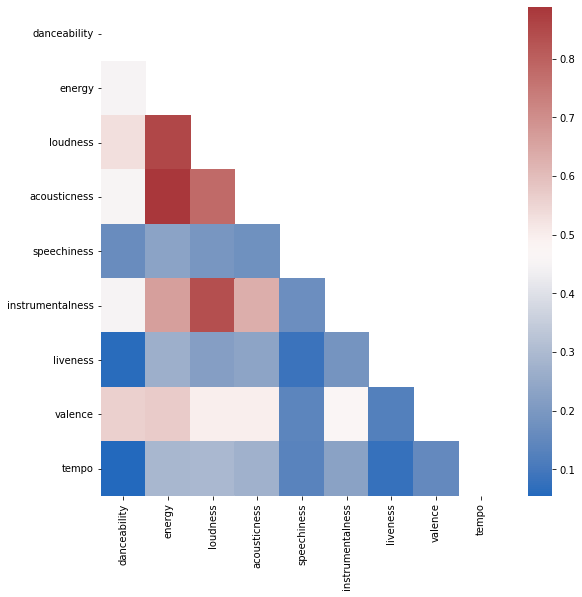

In [ ]:
corr = df.corr().abs()

#Create a mask for the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(9, 9))
sns.heatmap(corr, mask=mask, cmap="vlag")

Create a correlation matrix


In [ ]:
corr_metrics = df.corr()
corr_metrics.style.background_gradient()

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
danceability,1.000000,0.449698,0.530613,-0.452618,0.164723,-0.451870,0.063336,0.559888,0.054461
energy,0.449698,1.000000,0.853483,-0.888587,0.230429,-0.665775,0.268376,0.570147,0.291229
loudness,0.530613,0.853483,1.000000,-0.779740,0.192266,-0.837178,0.219956,0.498206,0.294005
acousticness,-0.452618,-0.888587,-0.779740,1.000000,-0.177780,0.633208,-0.235667,-0.500655,-0.274517
speechiness,0.164723,0.230429,0.192266,-0.177780,1.000000,-0.168840,0.084178,0.139356,0.132723
instrumentalness,-0.451870,-0.665775,-0.837178,0.633208,-0.168840,1.000000,-0.188008,-0.465124,-0.227645
liveness,0.063336,0.268376,0.219956,-0.235667,0.084178,-0.188008,1.000000,0.124696,0.079072
valence,0.559888,0.570147,0.498206,-0.500655,0.139356,-0.465124,0.124696,1.000000,0.153412
tempo,0.054461,0.291229,0.294005,-0.274517,0.132723,-0.227645,0.079072,0.153412,1.000000


https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python

Most of the variables do not have a high correlation with other variables. Need to filter out the extremely highly correlated pairs and examine them.

In [ ]:
sol = (corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool)).stack().sort_values(ascending=False))
for index, value in sol.items():
    if (value > 0.75) or (value < -0.75):
        print(index, value)

('energy', 'acousticness') 0.8885870208722179
('energy', 'loudness') 0.8534829395801596
('loudness', 'instrumentalness') 0.837178470738626
('loudness', 'acousticness') 0.7797403493516432


In [ ]:
corr = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

In [ ]:
to_drop = [column for column in corr.columns if any(corr[column] > 0.9)]
print(to_drop)

[]


In [ ]:
features = df.drop(to_drop,axis=1)
print(features.head())

   danceability  energy  loudness  acousticness  speechiness  \
0         0.445   0.537    -8.532         0.695       0.0400   
1         0.604   0.366    -7.519         0.578       0.0282   
2         0.824   0.300    -6.678         0.854       0.0565   
3         0.391   0.335   -10.064         0.389       0.0763   
4         0.559   0.763    -4.160         0.403       0.1050   

   instrumentalness  liveness  valence    tempo  
0          0.000017    0.0944    0.131  122.769  
1          0.000000    0.1330    0.130  141.981  
2          0.000000    0.1740    0.227  112.867  
3          0.000000    0.1020    0.116  174.185  
4          0.000000    0.1270    0.349   91.069  


In [ ]:
features

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
0,0.445,0.537,-8.532,0.695000,0.0400,0.000017,0.0944,0.131,122.769
1,0.604,0.366,-7.519,0.578000,0.0282,0.000000,0.1330,0.130,141.981
2,0.824,0.300,-6.678,0.854000,0.0565,0.000000,0.1740,0.227,112.867
3,0.391,0.335,-10.064,0.389000,0.0763,0.000000,0.1020,0.116,174.185
4,0.559,0.763,-4.160,0.403000,0.1050,0.000000,0.1270,0.349,91.069
...,...,...,...,...,...,...,...,...,...
3058,0.547,0.792,-5.645,0.000383,0.0350,0.000259,0.1060,0.395,97.998
3059,0.555,0.883,-3.426,0.001140,0.0341,0.041000,0.8680,0.507,125.020
3060,0.408,0.965,-4.232,0.000007,0.0500,0.000402,0.1100,0.349,136.018
3061,0.641,0.732,-7.570,0.013900,0.0795,0.000003,0.0620,0.763,92.057


## Create Instance of Feature Selector

In [ ]:
fs = FeatureSelector(data = features, labels = labels)

## Missing Value:

The first feature selection method is straightforward: find any columns with a missing fraction greater than a specified threshold. For this example we will use a threhold of 0.6 which corresponds to finding features with more than 60% missing values. (This method does not one-hot encode the features first).

0 features with greater than 0.60 missing values.



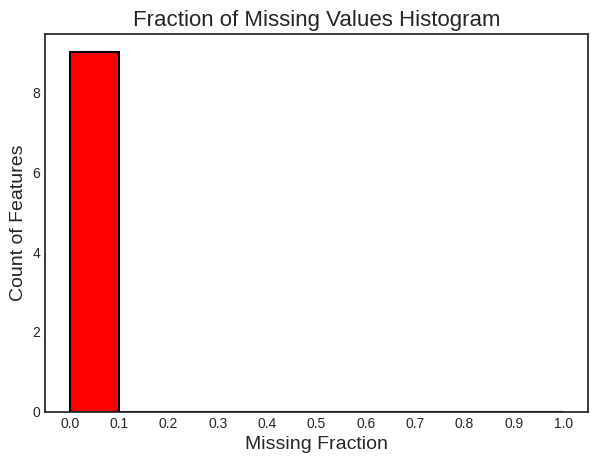

In [ ]:
fs.identify_missing(missing_threshold=0.6)
missing_features = fs.ops['missing']
missing_features[:10]
fs.plot_missing()

## Single Unique Value

0 features with a single unique value.



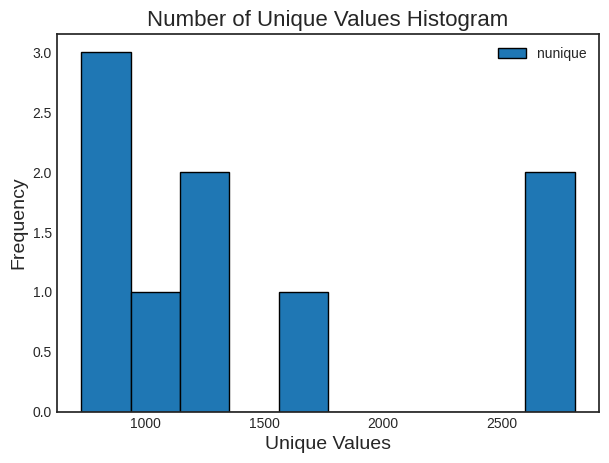

In [ ]:
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
fs.plot_unique()

## Feature Importances


In [ ]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc_mu', n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.



In [ ]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 9 original features
There are 0 one-hot features


In [ ]:
fs.data_all.head(10)


,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
0,0.445,0.537,-8.532,0.695,0.0400,0.000017,0.0944,0.1310,122.769
1,0.604,0.366,-7.519,0.578,0.0282,0.000000,0.1330,0.1300,141.981
2,0.824,0.300,-6.678,0.854,0.0565,0.000000,0.1740,0.2270,112.867
3,0.391,0.335,-10.064,0.389,0.0763,0.000000,0.1020,0.1160,174.185
4,0.559,0.763,-4.160,0.403,0.1050,0.000000,0.1270,0.3490,91.069
5,0.471,0.396,-6.654,0.770,0.0336,0.000000,0.0729,0.2630,149.609
6,0.311,0.485,-5.726,0.701,0.0365,0.000000,0.0726,0.2250,77.355
7,0.629,0.306,-11.735,0.884,0.0424,0.077600,0.1240,0.1910,76.994
8,0.478,0.339,-7.355,0.688,0.0544,0.000000,0.1040,0.2880,145.441
9,0.567,0.267,-6.502,0.839,0.0299,0.000001,0.0890,0.0592,110.011


The feature importance plot using plot_feature_importances will show us the plot_n most important features (on a normalized scale where the features sum to 1). It also shows us the cumulative feature importance versus the number of features.

When we plot the feature importances, we can pass in a threshold which identifies the number of features required to reach a specified cumulative feature importance. For example, threshold = 0.99 will tell us the number of features needed to account for 99% of the total importance.

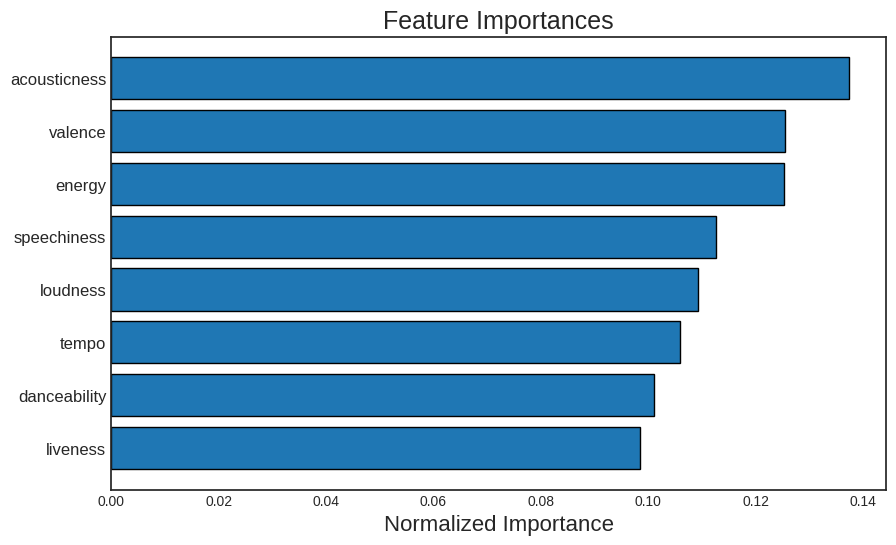

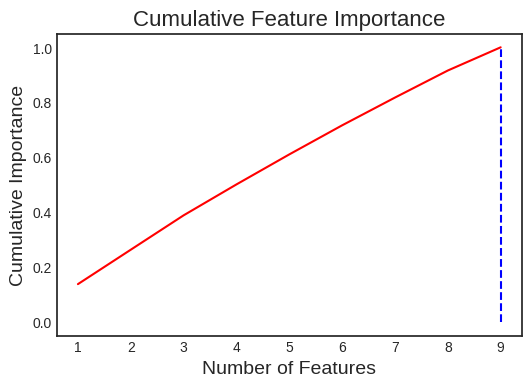

9 features required for 0.99 of cumulative importance


In [ ]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [ ]:
fs.feature_importances.head

<bound method NDFrame.head of             feature  importance  normalized_importance  cumulative_importance
0      acousticness       702.5               0.137422               0.137422
1           valence       640.9               0.125372               0.262793
2            energy       640.0               0.125196               0.387989
3       speechiness       575.7               0.112617               0.500606
4          loudness       558.9               0.109331               0.609937
5             tempo       541.3               0.105888               0.715826
6      danceability       517.0               0.101135               0.816960
7          liveness       503.6               0.098513               0.915473
8  instrumentalness       432.1               0.084527               1.000000>

In [ ]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,acousticness,702.5,0.137422,0.137422
1,valence,640.9,0.125372,0.262793
2,energy,640.0,0.125196,0.387989
3,speechiness,575.7,0.112617,0.500606
4,loudness,558.9,0.109331,0.609937
5,tempo,541.3,0.105888,0.715826
6,danceability,517.0,0.101135,0.816960
7,liveness,503.6,0.098513,0.915473
8,instrumentalness,432.1,0.084527,1.000000


We could use these results to select only the 'n' most important features. For example, if we want the top 30 most importance, we could do the following.



## Removing Features

Once we have identified the features to remove, we have a number of ways to drop the features. We can access any of the feature lists in the removal_ops dictionary and remove the columns manually. We also can use the remove method, passing in the methods that identified the features we want to remove.

This method returns the resulting data which we can then use for machine learning. The original data will still be accessible in the data attribute of the Feature Selector.

In [ ]:
train_no_missing = fs.remove(methods = ['missing'])
train_no_missing_zero = fs.remove(methods = ['missing', 'zero_importance'])


Removed 0 features.
Removed 0 features.


To remove the features from all of the methods, pass in method='all'. Before we do this, we can check how many features will be removed using check_removal. This returns a list of all the features that have been idenfitied for removal.



In [ ]:
all_to_remove = fs.check_removal()
all_to_remove

Total of 0 features identified for removal


[]

In [ ]:
features_removed = fs.remove(methods = 'all')

['missing', 'single_unique', 'zero_importance'] methods have been run

Removed 0 features.


In [ ]:
features_removed

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
0,0.445,0.537,-8.532,0.695000,0.0400,0.000017,0.0944,0.131,122.769
1,0.604,0.366,-7.519,0.578000,0.0282,0.000000,0.1330,0.130,141.981
2,0.824,0.300,-6.678,0.854000,0.0565,0.000000,0.1740,0.227,112.867
3,0.391,0.335,-10.064,0.389000,0.0763,0.000000,0.1020,0.116,174.185
4,0.559,0.763,-4.160,0.403000,0.1050,0.000000,0.1270,0.349,91.069
...,...,...,...,...,...,...,...,...,...
3058,0.547,0.792,-5.645,0.000383,0.0350,0.000259,0.1060,0.395,97.998
3059,0.555,0.883,-3.426,0.001140,0.0341,0.041000,0.8680,0.507,125.020
3060,0.408,0.965,-4.232,0.000007,0.0500,0.000402,0.1100,0.349,136.018
3061,0.641,0.732,-7.570,0.013900,0.0795,0.000003,0.0620,0.763,92.057


In [ ]:
features_removed = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'single_unique', 'zero_importance'] methods have been run

Removed 0 features including one-hot features.


In [ ]:
print('Original Number of Features :', df.shape[1])
print('Final Number of Features: ', features_removed.shape[1])

Original Number of Features : 9
Final Number of Features:  9


In [ ]:
features_removed.shape

(3063, 9)

In [ ]:
# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features_removed)

# Training model with dropping features

## Split to train data and test data

Given the small number of training data, I set 80% as training data and 20% as testing data. 

For hyparameter tuning, given the small dataset, I will use the same train dataset to tune.

For the split of data, I make sure every class has the same number of data to train and test.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Music-MOOD/Dataset/dataset_mood.csv")
y = df.genre
X = features_removed

# Use `label` to split data evenly and drop `label` column after split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df.genre, random_state=77)

In [ ]:
X_train

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
2980,0.613,0.953,-3.435,0.00148,0.0855,0.000582,0.1520,0.5370,105.046
788,0.669,0.727,-7.588,0.13900,0.0353,0.000000,0.1230,0.8070,102.322
1733,0.740,0.731,-7.714,0.44100,0.0588,0.000076,0.0613,0.5630,100.033
1905,0.396,0.201,-15.411,0.69200,0.0319,0.000270,0.1030,0.0972,144.712
2941,0.468,0.627,-5.085,0.02810,0.0476,0.000008,0.1100,0.1590,179.642
...,...,...,...,...,...,...,...,...,...
510,0.581,0.225,-12.764,0.92300,0.0333,0.000216,0.1170,0.3730,87.120
259,0.655,0.464,-12.311,0.09000,0.0565,0.000007,0.1270,0.5660,80.003
2423,0.779,0.963,-2.125,0.03340,0.0399,0.493000,0.6640,0.7590,127.941
1487,0.718,0.191,-19.746,0.88100,0.0459,0.921000,0.1350,0.5210,80.001


Normalize the data



In [ ]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = sc.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [ ]:
# Save the Modle to file in the current working directory

Pkl_Filename = "/content/drive/MyDrive/Dataset/Music-genre-classification/model/musci_emotion_scaler.pkl"  

with open(Pkl_Filename,'wb') as file: 
    pickle.dump(sc, file)

## Classifier simple pridiction

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model

In [ ]:
classifiers = [['LogisticRegression :', LogisticRegression()],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()],['BaggingClassifier:',BaggingClassifier()]]

predictions_df = pd.DataFrame()
predictions_df['action'] = y_test

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train.ravel())
    predictions = classifier.predict(X_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))

LogisticRegression : 0.6900489396411092
ExtraTreesClassifier : 0.6933115823817292
DecisionTree : 0.5481239804241436
RandomForest : 0.66721044045677
Naive Bayes : 0.6574225122349103
KNeighbours : 0.6264274061990212
SVM : 0.6818923327895595
AdaBoostClassifier : 0.6117455138662317
GradientBoostingClassifier:  0.66721044045677
[14:49:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB : 0.6492659053833605
BaggingClassifier: 0.6557911908646004


## XGB

In [ ]:
xg = xgb.XGBClassifier(objective ='multi:softmax', 
                           num_class = 10,
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1,
                           n_estimators = 50)
xg.fit(X_train,y_train)
y_train_pred = xg.predict(X_train)
y_test_pred = xg.predict(X_test)

[14:49:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:

print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.7733686840554732
Test F1: 0.7057700794662265 

Train Accuracy: 0.769795918367347
Test Accuracy: 0.6998368678629691 

Train Recall: 0.769795918367347
Test Recall: 0.6998368678629691
Training accuracy: 0.769795918367347
Training:
               precision    recall  f1-score   support

        calm       0.97      0.73      0.83       665
   energetic       0.80      0.77      0.79       671
       happy       0.67      0.75      0.71       625
         sad       0.68      0.84      0.75       489

    accuracy                           0.77      2450
   macro avg       0.78      0.77      0.77      2450
weighted avg       0.79      0.77      0.77      2450

Testing accuracy: 0.6998368678629691
Testing:
               precision    recall  f1-score   support

        calm       0.96      0.72      0.83       167
   energetic       0.73      0.64      0.68       168
       happy       0.57      0.67      0.61       156
         sad       0.62      0.80      0.70       122

    a

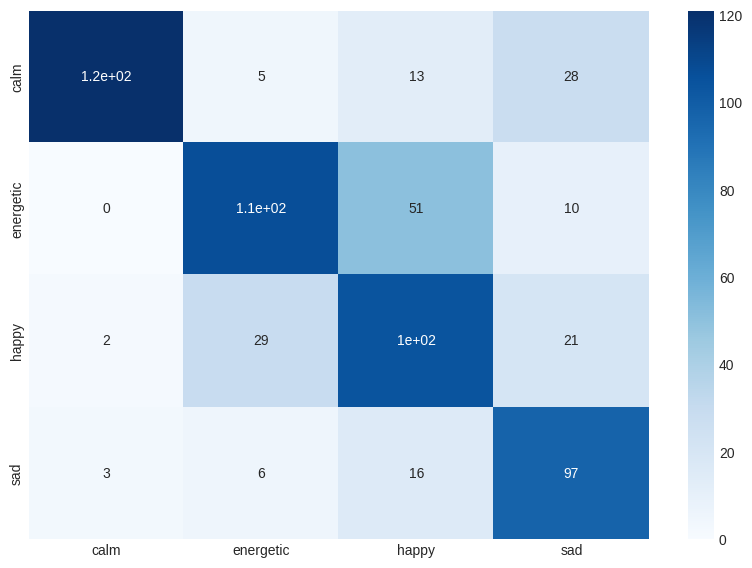

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores = {
    'XGB': {
        'Train': accuracy_score(y_train, xg.predict(X_train)),
        'Test': accuracy_score(y_test, xg.predict(X_test)),
    },
}

## RandomForest

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=1000)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.9836850041501722
Test F1: 0.6905010120165825 

Train Accuracy: 0.9836734693877551
Test Accuracy: 0.6851549755301795 

Train Recall: 0.9836734693877551
Test Recall: 0.6851549755301795
Training accuracy: 0.9836734693877551
Training:
               precision    recall  f1-score   support

        calm       1.00      0.97      0.99       665
   energetic       0.98      0.98      0.98       671
       happy       0.98      0.98      0.98       625
         sad       0.97      1.00      0.98       489

    accuracy                           0.98      2450
   macro avg       0.98      0.98      0.98      2450
weighted avg       0.98      0.98      0.98      2450

Testing accuracy: 0.6851549755301795
Testing:
               precision    recall  f1-score   support

        calm       0.91      0.74      0.82       167
   energetic       0.70      0.62      0.66       168
       happy       0.56      0.67      0.61       156
         sad       0.61      0.70      0.65       122

  

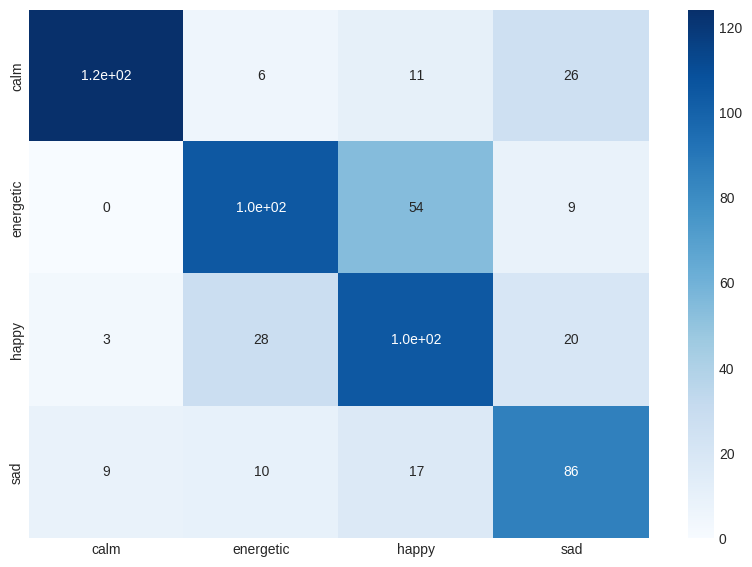

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['Random Forest'] = {
        'Train': accuracy_score(y_train, rf_clf.predict(X_train)),
        'Test': accuracy_score(y_test, rf_clf.predict(X_test)),
    }

## Logistic regression

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [ ]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.6755814270703799
Test F1: 0.677200270751986 

Train Accuracy: 0.6710204081632654
Test Accuracy: 0.6737357259380098 

Train Recall: 0.6710204081632654
Test Recall: 0.6737357259380098
Training accuracy: 0.6710204081632654
Training:
               precision    recall  f1-score   support

        calm       0.95      0.71      0.81       665
   energetic       0.62      0.71      0.66       671
       happy       0.53      0.53      0.53       625
         sad       0.65      0.75      0.69       489

    accuracy                           0.67      2450
   macro avg       0.69      0.67      0.67      2450
weighted avg       0.69      0.67      0.68      2450

Testing accuracy: 0.6737357259380098
Testing:
               precision    recall  f1-score   support

        calm       0.97      0.72      0.83       167
   energetic       0.61      0.73      0.66       168
       happy       0.52      0.49      0.50       156
         sad       0.66      0.77      0.71       122

   

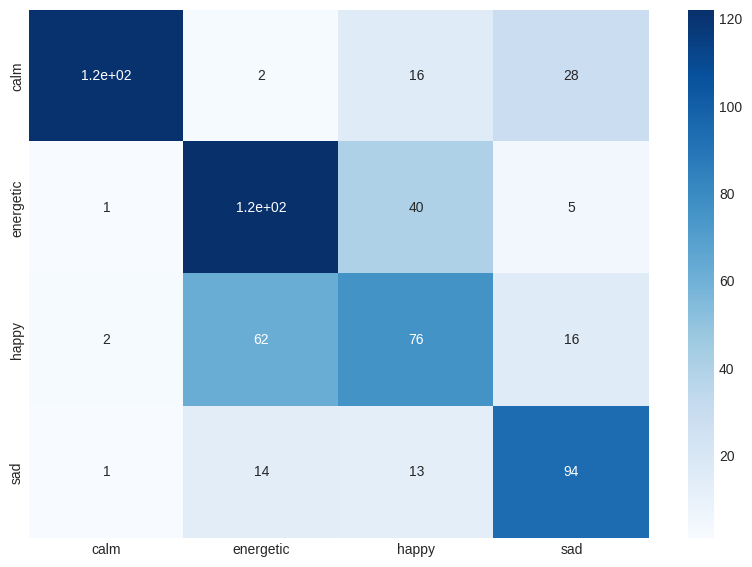

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['Logistic Regression'] = {
        'Train': accuracy_score(y_train, lm.predict(X_train)),
        'Test': accuracy_score(y_test, lm.predict(X_test)),
    }

## Extra Tree

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ex_tree_clf = ExtraTreesClassifier(n_estimators=1000, max_features=3, random_state=42)
ex_tree_clf.fit(X_train, y_train)


ExtraTreesClassifier(max_features=3, n_estimators=1000, random_state=42)

In [ ]:
y_train_pred = ex_tree_clf.predict(X_train)
y_test_pred = ex_tree_clf.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.9836617734970092
Test F1: 0.6958913978956776 

Train Accuracy: 0.9836734693877551
Test Accuracy: 0.6916802610114192 

Train Recall: 0.9836734693877551
Test Recall: 0.6916802610114192
Training accuracy: 0.9836734693877551
Training:
               precision    recall  f1-score   support

        calm       0.98      1.00      0.99       665
   energetic       0.97      1.00      0.98       671
       happy       1.00      0.97      0.98       625
         sad       1.00      0.97      0.98       489

    accuracy                           0.98      2450
   macro avg       0.99      0.98      0.98      2450
weighted avg       0.98      0.98      0.98      2450

Testing accuracy: 0.6916802610114192
Testing:
               precision    recall  f1-score   support

        calm       0.88      0.75      0.81       167
   energetic       0.71      0.66      0.69       168
       happy       0.56      0.65      0.60       156
         sad       0.64      0.70      0.67       122

  

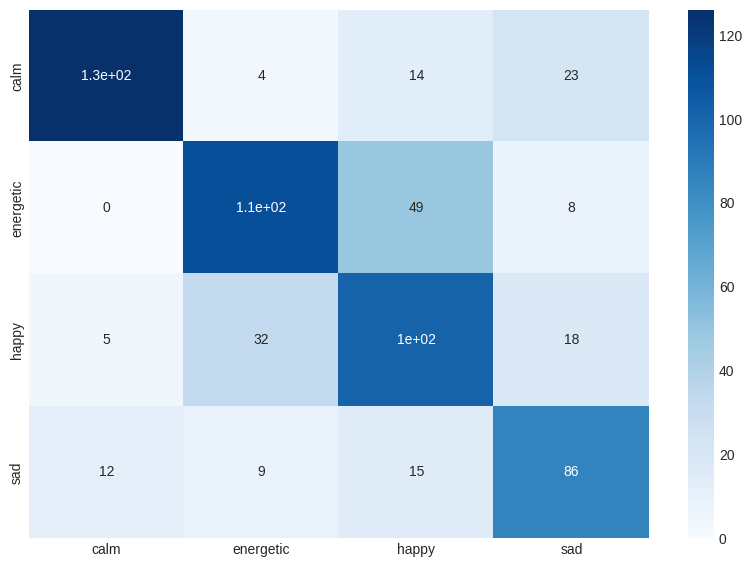

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['ExtraTreeClassifier'] = {
        'Train': accuracy_score(y_train, ex_tree_clf.predict(X_train)),
        'Test': accuracy_score(y_test, ex_tree_clf.predict(X_test)),
    }

## SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# parameter grid for our search
parameters = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4], # only applies to kernel == 'poly'
    'kernel': ('linear', 'rbf', 'poly')
}

# initiating our support vector machine
svm = svm.SVC(gamma='scale',
              probability=True,
              random_state=42)
classifier = GridSearchCV(estimator=svm,
                          param_grid=parameters,
                          cv=5)

# fitting the model
svm_fit = classifier.fit(X_train, y_train)

In [ ]:
y_train_pred = svm_fit.predict(X_train)
y_test_pred = svm_fit.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.7108472073073869
Test F1: 0.6892289554097218 

Train Accuracy: 0.7053061224489796
Test Accuracy: 0.6818923327895595 

Train Recall: 0.7053061224489796
Test Recall: 0.6818923327895595
Training accuracy: 0.7053061224489796
Training:
               precision    recall  f1-score   support

        calm       0.97      0.70      0.81       665
   energetic       0.71      0.66      0.68       671
       happy       0.58      0.69      0.63       625
         sad       0.65      0.79      0.71       489

    accuracy                           0.71      2450
   macro avg       0.73      0.71      0.71      2450
weighted avg       0.73      0.71      0.71      2450

Testing accuracy: 0.6818923327895595
Testing:
               precision    recall  f1-score   support

        calm       0.98      0.71      0.82       167
   energetic       0.69      0.64      0.66       168
       happy       0.53      0.63      0.58       156
         sad       0.63      0.77      0.69       122

  

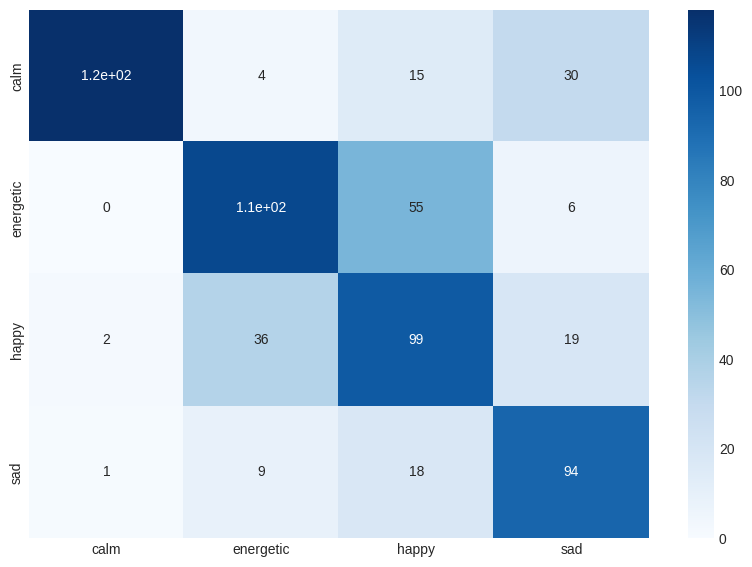

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['SVM'] = {
        'Train': accuracy_score(y_train, svm_fit.predict(X_train)),
        'Test': accuracy_score(y_test, svm_fit.predict(X_test)),
    }

## Deep learning

In [ ]:
#我用來構建神經網絡的代碼：
def base_model():
    #你可以通过将网络层实例的列表传递给 Sequential 的构造器，来创建一个 Sequential 模型：
    model = Sequential()#定義模型
    #Add 1 layer with 8 nodes,# Input - Layer
    model.add(Dense(8,input_dim=9,activation='relu'))
    #Add 1 layer with softmax function (activation)
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [ ]:
#Configure the model
dl = KerasClassifier(build_fn=base_model,epochs=300,batch_size=20,verbose=0)
dl._estimator_type = "classifier"

In [ ]:
cnn_pipe = Pipeline([('scaler', sc), ('cnn', dl)])

In [ ]:
dl.fit(X_train,y_train,batch_size=None,)

In [ ]:
dl.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_pred = dl.predict(X_train)
y_test_pred = dl.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.7076624390502135
Test F1: 0.6874423897366523 

Train Accuracy: 0.7028571428571428
Test Accuracy: 0.6818923327895595 

Train Recall: 0.7028571428571428
Test Recall: 0.6818923327895595
Training accuracy: 0.7028571428571428
Training:
               precision    recall  f1-score   support

        calm       0.96      0.72      0.82       665
   energetic       0.70      0.70      0.70       671
       happy       0.57      0.61      0.59       625
         sad       0.64      0.80      0.71       489

    accuracy                           0.70      2450
   macro avg       0.72      0.71      0.71      2450
weighted avg       0.73      0.70      0.71      2450

Testing accuracy: 0.6818923327895595
Testing:
               precision    recall  f1-score   support

        calm       0.98      0.72      0.83       167
   energetic       0.69      0.66      0.67       168
       happy       0.52      0.55      0.54       156
         sad       0.62      0.82      0.70       122

  

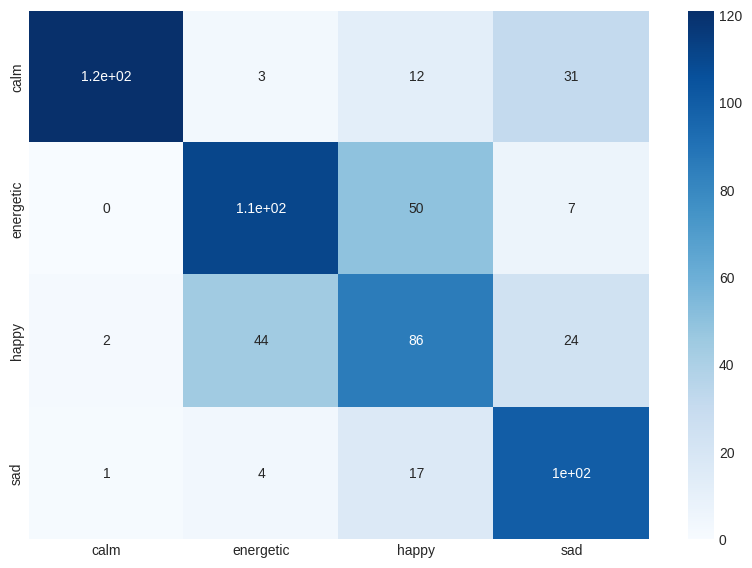

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['Neural network'] = {
        'Train': accuracy_score(y_train, dl.predict(X_train)),
        'Test': accuracy_score(y_test, dl.predict(X_test)),
    }

## Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

# configuring 
vc = VotingClassifier(
    
    # all classifiers we just gridsearched
    estimators=[
        ('XGB', xg),
        ('Randome Forest', rf_clf),
        ('Logistic regression', lm),
        ('Extra Tree', ex_tree_clf),
        ('SVM', svm_fit),
        ('Neural network',dl),

    ], 
    
    # soft = probabilities are taken into account
    # hard = only the outcome counts
    voting='soft',
    
    #  can add weights, as well. E.g.
    # weights=[2,3,2,3,2] 
    
)

#fitting
vc = vc.fit(X_train, y_train)

[15:08:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
y_train_pred = vc.predict(X_train)
y_test_pred = vc.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.9114585042620159
Test F1: 0.7098433332808101 

Train Accuracy: 0.9110204081632653
Test Accuracy: 0.7047308319738989 

Train Recall: 0.9110204081632653
Test Recall: 0.7047308319738989
Training accuracy: 0.9110204081632653
Training:
               precision    recall  f1-score   support

        calm       0.98      0.86      0.91       665
   energetic       0.94      0.94      0.94       671
       happy       0.90      0.92      0.91       625
         sad       0.83      0.94      0.88       489

    accuracy                           0.91      2450
   macro avg       0.91      0.91      0.91      2450
weighted avg       0.92      0.91      0.91      2450

Testing accuracy: 0.7047308319738989
Testing:
               precision    recall  f1-score   support

        calm       0.95      0.72      0.82       167
   energetic       0.71      0.68      0.70       168
       happy       0.57      0.63      0.60       156
         sad       0.64      0.80      0.71       122

  

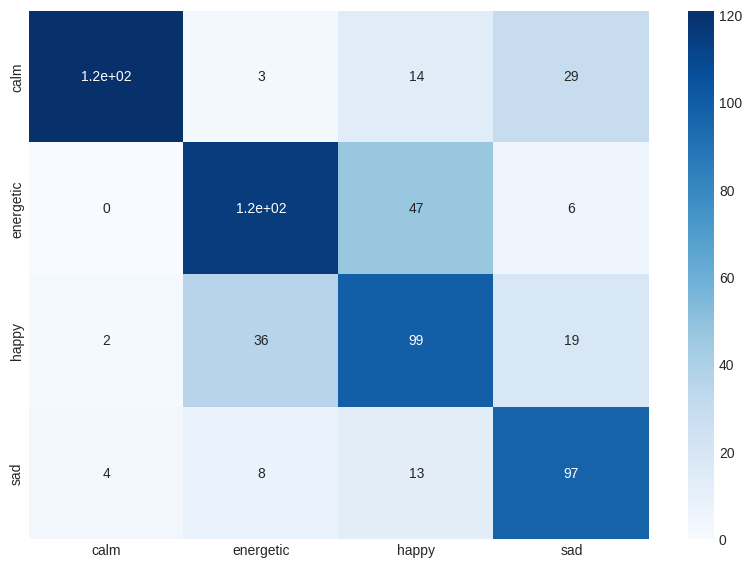

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['Soft_VotingClissifier'] = {
        'Train': accuracy_score(y_train, vc.predict(X_train)),
        'Test': accuracy_score(y_test, vc.predict(X_test)),
    }

## hard voting

In [ ]:
# configuring 
hard = VotingClassifier(
    
    # all classifiers we just gridsearched
    estimators=[
        ('XGB', xg),
        ('Randome Forest', rf_clf),
        ('Logistic regression', lm),
        ('Extra Tree', ex_tree_clf),
        ('SVM', svm_fit),
        ('Neural network',dl),

    ], 
    
    # soft = probabilities are taken into account
    # hard = only the outcome counts
    voting='hard',
    
    #  can add weights, as well. E.g.
    #weights=[2,3,2,3,2] 
    
)

# fitting
hard = hard.fit(X_train, y_train)

[15:12:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
y_train_pred = hard.predict(X_train)
y_test_pred = hard.predict(X_test)
print('Train F1:',metrics.f1_score(y_train, y_train_pred, average='weighted'))
print('Test F1:',metrics.f1_score(y_test, y_test_pred, average='weighted'),'\n')

print('Train Accuracy:',metrics.accuracy_score(y_train, y_train_pred))
print('Test Accuracy:',metrics.accuracy_score(y_test, y_test_pred),'\n')

print('Train Recall:',metrics.recall_score(y_train, y_train_pred,average='weighted'))
print('Test Recall:',metrics.recall_score(y_test, y_test_pred,average='weighted'))

target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_train_pred)}')
print(f'Training:\n {classification_report(y_train, y_train_pred, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_test_pred)}')
print(f'Testing:\n {classification_report(y_test, y_test_pred, labels=target_names)}')

Train F1: 0.7886248165257215
Test F1: 0.7138011774038988 

Train Accuracy: 0.786530612244898
Test Accuracy: 0.7079934747145188 

Train Recall: 0.786530612244898
Test Recall: 0.7079934747145188
Training accuracy: 0.786530612244898
Training:
               precision    recall  f1-score   support

        calm       0.97      0.75      0.85       665
   energetic       0.77      0.84      0.81       671
       happy       0.72      0.73      0.73       625
         sad       0.71      0.82      0.76       489

    accuracy                           0.79      2450
   macro avg       0.79      0.79      0.79      2450
weighted avg       0.80      0.79      0.79      2450

Testing accuracy: 0.7079934747145188
Testing:
               precision    recall  f1-score   support

        calm       0.96      0.73      0.83       167
   energetic       0.71      0.71      0.71       168
       happy       0.58      0.65      0.61       156
         sad       0.64      0.75      0.69       122

    a

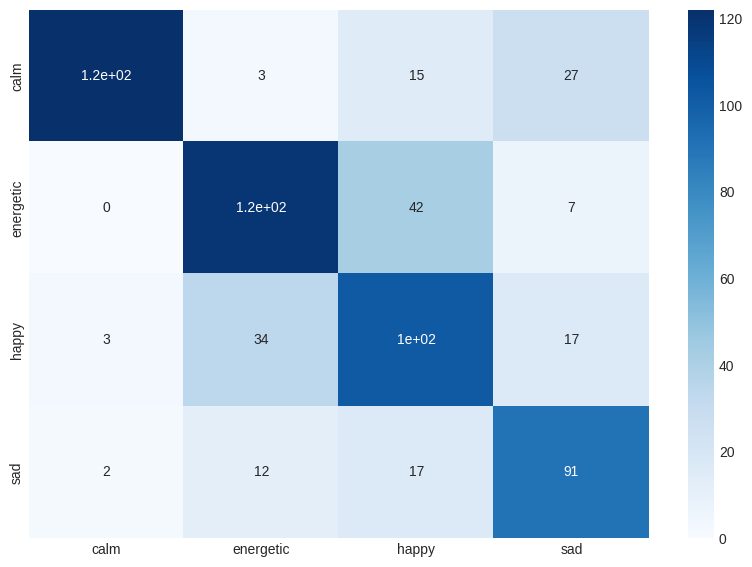

In [ ]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

In [ ]:
scores['Hard_VotingClissifier'] = {
        'Train': accuracy_score(y_train, hard.predict(X_train)),
        'Test': accuracy_score(y_test, hard.predict(X_test)),
    }

# Model Comparison(classification)


In [ ]:
scores_df = pd.DataFrame(scores)
cf= scores_df.drop(['VotingClissifier'],axis=1)
cf

,XGB,Random Forest,Logistic Regression,ExtraTreeClassifier,SVM,Neural network,Hard_VotingClissifier,Soft_VotingClissifier
Train,0.769796,0.983673,0.671020,0.983673,0.705306,0.702857,0.786531,0.911020
Test,0.699837,0.685155,0.673736,0.691680,0.681892,0.681892,0.707993,0.704731


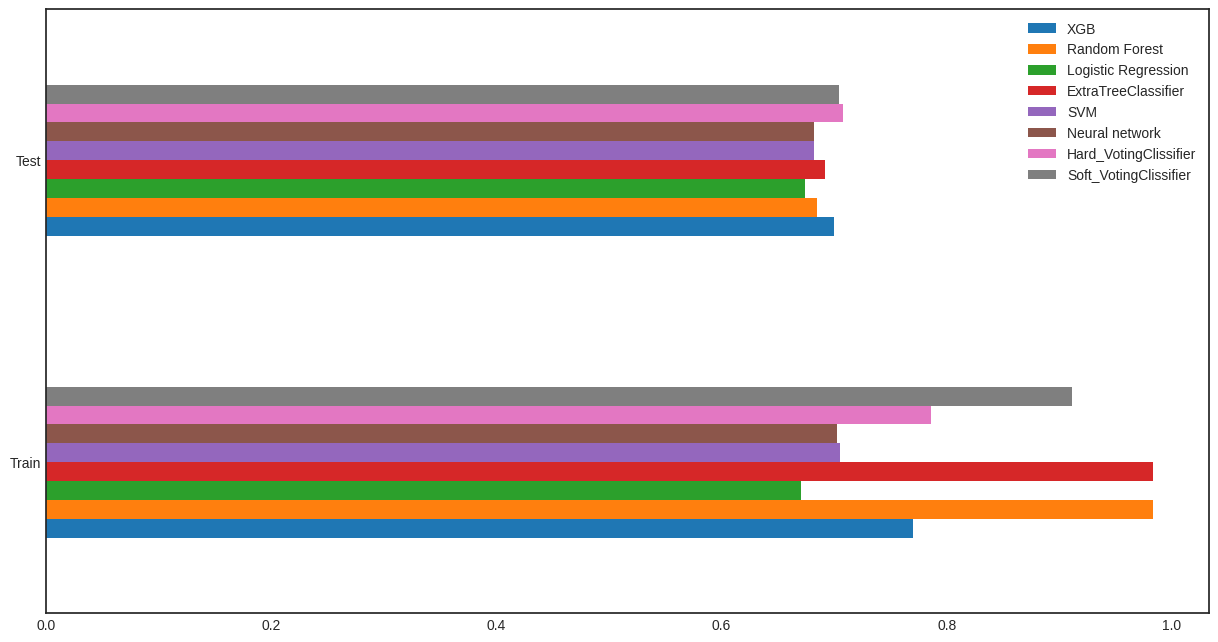

In [ ]:
cf.plot(kind='barh', figsize=(15, 8))


# Saving the model and using to model to predict

how to use the model：
https://www.kaggle.com/code/prmohanty/python-how-to-save-and-load-ml-models/notebook

save the voting classifier

In [ ]:
# Save the Modle to file in the current working directory

Pkl_Filename = "/content/drive/MyDrive/Dataset/Music-genre-classification/model/musci_emotion_voting_classifier2.pkl"  

with open(Pkl_Filename,'wb') as file: 
    pickle.dump(vc, file)

INFO:tensorflow:Assets written to: ram:///tmp/tmpxlih_vfu/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpeddooh10/assets


In [ ]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    model = pickle.load(file)

model

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(alpha=1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.5,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=4, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_est...
                                                 solver='liblinear')),

## Split to train data and test data

Given the small number of training data, I set 80% as training data and 20% as testing data. 

For hyparameter tuning, given the small dataset, I will use the same train dataset to tune.

For the split of data, I make sure every class has the same number of data to train and test.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Music-MOOD/Dataset/dataset_mood.csv')

y = df.genre
X = features_removed

# Use `label` to split data evenly and drop `label` column after split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df.genre, random_state=77)

In [ ]:
X_train

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
2980,0.613,0.953,-3.435,0.00148,0.0855,0.000582,0.1520,0.5370,105.046
788,0.669,0.727,-7.588,0.13900,0.0353,0.000000,0.1230,0.8070,102.322
1733,0.740,0.731,-7.714,0.44100,0.0588,0.000076,0.0613,0.5630,100.033
1905,0.396,0.201,-15.411,0.69200,0.0319,0.000270,0.1030,0.0972,144.712
2941,0.468,0.627,-5.085,0.02810,0.0476,0.000008,0.1100,0.1590,179.642
...,...,...,...,...,...,...,...,...,...
510,0.581,0.225,-12.764,0.92300,0.0333,0.000216,0.1170,0.3730,87.120
259,0.655,0.464,-12.311,0.09000,0.0565,0.000007,0.1270,0.5660,80.003
2423,0.779,0.963,-2.125,0.03340,0.0399,0.493000,0.6640,0.7590,127.941
1487,0.718,0.191,-19.746,0.88100,0.0459,0.921000,0.1350,0.5210,80.001


**Normalize** the data



In [ ]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = sc.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [ ]:
X_test

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
2348,0.270433,1.324870,0.677563,-0.978227,-0.022793,-0.534827,1.437946,1.044566,-0.594223
1155,-0.189472,-0.469608,-0.036871,1.243335,-0.235621,-0.535073,0.445385,0.041063,0.881990
12,-1.208249,-0.391304,0.372009,0.505661,-0.554863,-0.535073,1.239434,-0.675724,-0.524353
1600,-1.935947,-1.285281,-1.298404,0.583311,-0.559851,1.993510,1.652340,-1.528701,1.287638
3057,-0.090505,0.675595,0.540082,-1.005239,-0.674579,-0.535010,1.096505,0.861387,-0.560299
...,...,...,...,...,...,...,...,...,...
2957,-0.154542,0.845255,0.630876,-0.995310,-0.513295,-0.535073,1.302958,0.268046,0.921372
1890,0.119072,0.029583,0.307261,0.591076,-0.613058,-0.366501,-0.261319,-0.086365,0.071907
2620,-0.329190,1.399912,0.577063,-1.005771,0.125189,-0.535017,-0.820330,-0.114240,0.581653
2386,0.474189,0.907246,0.762460,-0.454608,-0.453437,-0.535073,1.239434,-0.086365,0.350110


save scale model

In [ ]:
# Use the Reloaded Model to 
# Calculate the accuracy score and predict target values

# Calculate the Score 
score = model.score(X_test, y_test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  


Test score: 70.47 %


In [ ]:
row = X_test.iloc[[1]]
row

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo
1155,-0.189472,-0.469608,-0.036871,1.243335,-0.235621,-0.535073,0.445385,0.041063,0.88199


In [ ]:
# Predict the Labels using the reloaded Model
Ypredict = model.predict(row)  

print("Prediction of the Music Genre : ",Ypredict[0].upper()) 

Prediction of the Music Genre :  SAD


In [ ]:
Ypredict

array(['sad'], dtype=object)